In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense

In [7]:
features_num = [
    'Total_flux', 'Peak_flux', 'EBV', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68', 'Mass_u68',
        'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flux_corr',
       'g_hsc_flux_corr', 'nb921_hsc_flux_corr', 'g_rcs_flux_corr'
]
    

features_cat = [
   "S_Code"
]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [4]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_filled_preprocessed.csv")

In [6]:
data.columns

Index(['Source_Name', 'Total_flux', 'Peak_flux', 'S_Code', 'EBV',
       'FUV_flux_corr', 'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr',
       'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'z_Subaru_flux_corr',
       'y_flux_corr', 'J_flux_corr', 'H_flux_corr', 'K_flux_corr',
       'Ks_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250',
       'F_SPIRE_350', 'F_SPIRE_500', 'Z_BEST', 'Mass_median', 'Mass_l68',
       'Mass_u68', 'Source', 'AGN_final', 'RadioAGN_final', 'Classification',
       'Radio_excess', 'AGNfrac_af', 'AGNfrac_af_16', 'AGNfrac_cg_s_16',
       'z_rcs_flux_corr', 'z_hsc_flux_corr', 'i_hsc_flux_corr',
       'i_rcs_flux_corr', 'i_flux_corr', 'y_hsc_flux_corr', 'r_flux_corr',
       'r_hsc_flux_corr', 'r_rcs_flux_corr', 'ch1_swire_flux_corr',
       'ch2_swire_flux_corr', 'ch3_swire_flux_corr', 'ch4_swire_flux_corr',
       'ch1_servs_flux_corr', 'ch2_servs_flux_corr', 'g_flu

In [8]:
data.isna().sum()

Source_Name            0
Total_flux             0
Peak_flux              0
S_Code                 0
EBV                    0
FUV_flux_corr          0
NUV_flux_corr          0
u_flux_corr            0
Bw_flux_corr           0
R_flux_corr            0
I_flux_corr            0
z_flux_corr            0
z_Subaru_flux_corr     0
y_flux_corr            0
J_flux_corr            0
H_flux_corr            0
K_flux_corr            0
Ks_flux_corr           0
ch1_flux_corr          0
ch2_flux_corr          0
ch3_flux_corr          0
ch4_flux_corr          0
F_MIPS_24              0
F_PACS_100             0
F_PACS_160             0
F_SPIRE_250            0
F_SPIRE_350            0
F_SPIRE_500            0
Z_BEST                 0
Mass_median            0
Mass_l68               0
Mass_u68               0
Source                 0
AGN_final              0
RadioAGN_final         0
Classification         0
Radio_excess           0
AGNfrac_af             0
AGNfrac_af_16          0
AGNfrac_cg_s_16        0


In [9]:
X = data[np.append(features_num, features_cat)]
y = data[y_column]

In [10]:
le = LabelEncoder()
labels = np.unique(y.astype(str))
y = le.fit_transform(y)

In [11]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [12]:
def one_hot(df, columns):
    """
    One-hot encoding a certain column in a dataframe
    """
    one_hot = pd.get_dummies(df[columns])
    df = df.drop(columns=columns, axis = 1)
    df = df.join(one_hot)
    return df

In [13]:
# Imputing missing categorical features
imp = SimpleImputer(strategy="most_frequent")

# Transforming the categorical data
X_train[features_cat] = imp.fit_transform(X_train[features_cat])
X_test[features_cat] = imp.transform(X_test[features_cat])

# One-hot encoding categorical features
X_train = one_hot(X_train, features_cat)
X_test = one_hot(X_test, features_cat)

# Standard scaling the numerical data
scaler = MinMaxScaler()

# Transforming the categorical data
X_train[features_num] = scaler.fit_transform(X_train[features_num])
X_test[features_num] = scaler.transform(X_test[features_num])

# Random forest

In [14]:
clf = RandomForestClassifier(n_estimators=50, 
                             max_features=None,
                             n_jobs=-1, 
                             class_weight="balanced", 
                             random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_features=None,
                       n_estimators=50, n_jobs=-1, random_state=42)

In [195]:
cv_score = cross_val_score(clf, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [196]:
print("Cross-validated Accuracy:", round(np.mean(cv_score), 5), "±", round(np.std(cv_score), 5))

Cross-validated Accuracy: 0.83311 ± 0.01399


In [15]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.7948    0.5688    0.6631      2581
quasar-like radio AGN / high-excitation radio galaxy     0.5055    0.1704    0.2548       270
                                     radio-quiet AGN     0.7060    0.5509    0.6189      1356
                                 star-forming galaxy     0.8587    0.9506    0.9023     11315

                                            accuracy                         0.8386     15522
                                           macro avg     0.7163    0.5602    0.6098     15522
                                        weighted avg     0.8286    0.8386    0.8265     15522



[]

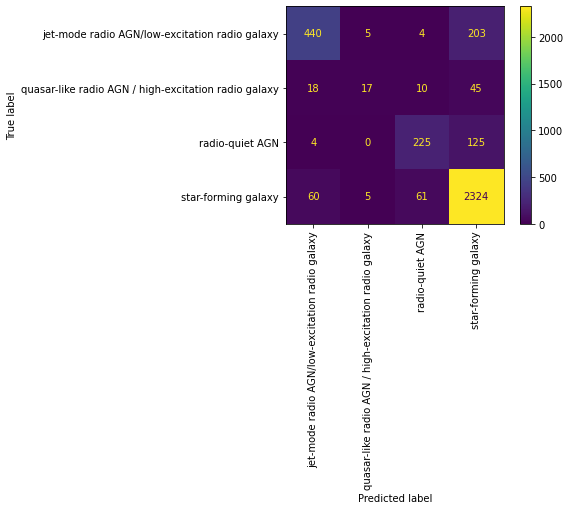

In [211]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# Lightgbm

In [229]:
import lightgbm as lgb
lightbm = lgb.LGBMClassifier(num_class=4, 
                             objective="multiclass",  
                             n_estimators=200, 
                             class_weight="balanced",
                             max_depth=7, 
                             num_leaves=32, 
                             min_child_samples=5,
                             reg_alpha=1,
                             reg_lambda=2)

In [230]:
lightbm.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', max_depth=8, min_child_samples=5,
               n_estimators=200, num_class=4, num_leaves=32,
               objective='multiclass', reg_alpha=1, reg_lambda=2)

In [231]:
cv_score_lgb = cross_val_score(lightbm, X_train, y_train, cv=32, n_jobs=-1, scoring="accuracy")

In [232]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_lgb), 5), "±", round(np.std(cv_score_lgb), 5))

Cross-validated Accuracy: 0.87436 ± 0.01571


In [233]:
y_pred = lightbm.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8178    0.8604    0.8386       652
quasar-like radio AGN / high-excitation radio galaxy     0.5536    0.3444    0.4247        90
                                     radio-quiet AGN     0.6752    0.8220    0.7414       354
                                 star-forming galaxy     0.9410    0.9114    0.9260      2450

                                            accuracy                         0.8787      3546
                                           macro avg     0.7469    0.7346    0.7327      3546
                                        weighted avg     0.8820    0.8787    0.8788      3546



[]

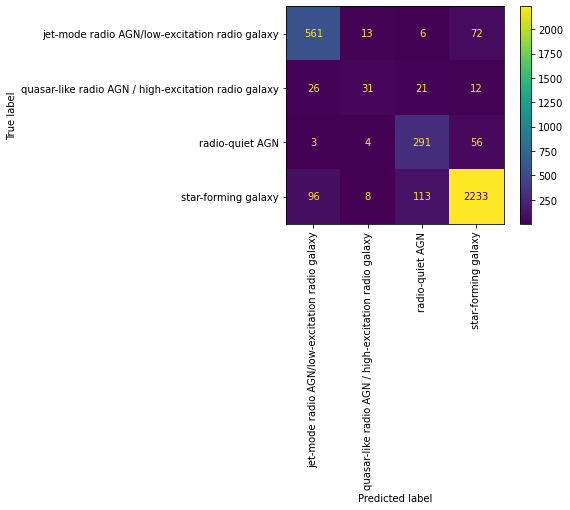

In [234]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

# XGBoost

In [20]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=10, 
                      reg_alpha=0, 
                      min_child_weight=0.2, 
                      reg_lambda=3,
                      gamma=0,
                      eta=0.3,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, )
bst = model.fit(X_train, y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)], verbose=True,)

[0]	validation_0-auc:0.91264
[1]	validation_0-auc:0.92477
[2]	validation_0-auc:0.93374
[3]	validation_0-auc:0.93741
[4]	validation_0-auc:0.94173
[5]	validation_0-auc:0.94487
[6]	validation_0-auc:0.94779
[7]	validation_0-auc:0.94990
[8]	validation_0-auc:0.95176
[9]	validation_0-auc:0.95378
[10]	validation_0-auc:0.95502
[11]	validation_0-auc:0.95612
[12]	validation_0-auc:0.95681
[13]	validation_0-auc:0.95772
[14]	validation_0-auc:0.95873
[15]	validation_0-auc:0.95950
[16]	validation_0-auc:0.96019
[17]	validation_0-auc:0.96082
[18]	validation_0-auc:0.96125
[19]	validation_0-auc:0.96177
[20]	validation_0-auc:0.96228
[21]	validation_0-auc:0.96258
[22]	validation_0-auc:0.96279
[23]	validation_0-auc:0.96330
[24]	validation_0-auc:0.96375
[25]	validation_0-auc:0.96402
[26]	validation_0-auc:0.96419
[27]	validation_0-auc:0.96433
[28]	validation_0-auc:0.96461
[29]	validation_0-auc:0.96481
[30]	validation_0-auc:0.96510
[31]	validation_0-auc:0.96521
[32]	validation_0-auc:0.96534
[33]	validation_0-au

[268]	validation_0-auc:0.96928
[269]	validation_0-auc:0.96927
[270]	validation_0-auc:0.96927
[271]	validation_0-auc:0.96928
[272]	validation_0-auc:0.96928
[273]	validation_0-auc:0.96929
[274]	validation_0-auc:0.96930
[275]	validation_0-auc:0.96929
[276]	validation_0-auc:0.96928
[277]	validation_0-auc:0.96929
[278]	validation_0-auc:0.96929
[279]	validation_0-auc:0.96930
[280]	validation_0-auc:0.96929
[281]	validation_0-auc:0.96929
[282]	validation_0-auc:0.96928
[283]	validation_0-auc:0.96928
[284]	validation_0-auc:0.96928
[285]	validation_0-auc:0.96928
[286]	validation_0-auc:0.96928
[287]	validation_0-auc:0.96927
[288]	validation_0-auc:0.96928
[289]	validation_0-auc:0.96927
[290]	validation_0-auc:0.96928
[291]	validation_0-auc:0.96928
[292]	validation_0-auc:0.96927
[293]	validation_0-auc:0.96926
[294]	validation_0-auc:0.96926
[295]	validation_0-auc:0.96927
[296]	validation_0-auc:0.96928
[297]	validation_0-auc:0.96928
[298]	validation_0-auc:0.96928


In [225]:
cv_score_xgb = cross_val_score(model, X_train, y_train, cv=8, n_jobs=-1, scoring="accuracy")

In [123]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

NameError: name 'cv_score_xgb' is not defined

In [21]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8720    0.7865    0.8271      2581
quasar-like radio AGN / high-excitation radio galaxy     0.7054    0.3370    0.4561       270
                                     radio-quiet AGN     0.7820    0.6932    0.7349      1356
                                 star-forming galaxy     0.9193    0.9639    0.9411     11315

                                            accuracy                         0.8998     15522
                                           macro avg     0.8197    0.6952    0.7398     15522
                                        weighted avg     0.8957    0.8998    0.8957     15522



[]

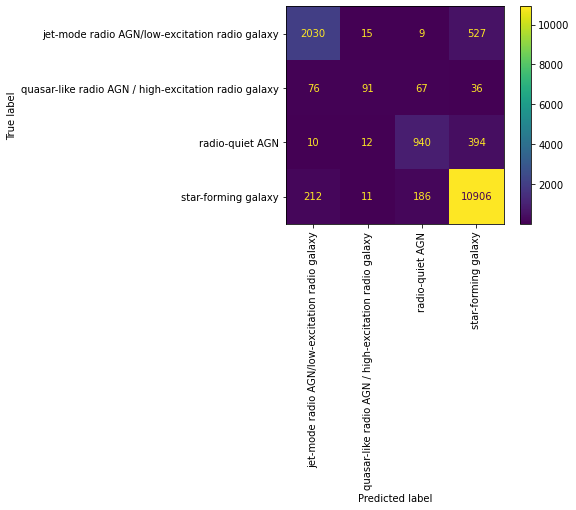

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.xticks(rotation = 90)
plt.plot()

## Hyperparameter fitting

In [10]:
import multiprocessing

multiprocessing.cpu_count()

192

In [11]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [12]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=8, 
                      reg_alpha=3, 
                      min_child_weight=0, 
                      reg_lambda=5,
                      gamma=0,
                      eta=0.2,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, 
                      early_stopping_rounds=30,)
bst = model.fit(X_train, y_train, 
                verbose=0, 
                eval_set=[(X_test, y_test)], 
                sample_weight=classes_weights)

In [12]:
# Metrics for hyperparameter tuning
metrics = {"Accuracy": "accuracy",
          "Balanced accuracy": "balanced_accuracy",
          "F1 score": "f1_weighted"}

In [13]:
# Parameter space
parameters = { 
         "max_depth": [8,9,10,11],
         "reg_alpha": [0,1,3,5,10], 
        "reg_lambda": [0,1,3,5,10],
        "gamma": [0,0.5,3],
        "eta": [0.1, 0.3],
        "min_child_weight": [0, 0.2, 0.5, 1]}

In [14]:
model = XGBClassifier(use_label_encoder=False,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, 
                      early_stopping_rounds=30,)

In [16]:
clf = GridSearchCV(estimator=model, 
                   param_grid=parameters,
                  scoring=metrics,
                  refit="Accuracy",
                  return_train_score=True,
                  n_jobs=128,
                  cv=3,
                  verbose=1)

grid = clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

Fitting 3 folds for each of 2400 candidates, totalling 7200 fits


/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
clf.best_params_, clf.best_score_

({'eta': 0.1,
  'gamma': 0,
  'max_depth': 10,
  'min_child_weight': 0.2,
  'reg_alpha': 0,
  'reg_lambda': 3},
 0.8753438593213124)

In [ ]:
({'eta': 0.1,
  'gamma': 0,
  'max_depth': 10,
  'min_child_weight': 0.2,
  'reg_alpha': 0,
  'reg_lambda': 3},
 0.8753438593213124)

In [25]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=10, 
                      reg_alpha=0, 
                      min_child_weight=0.2, 
                      reg_lambda=3,
                      gamma=0,
                      eta=0.1,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=200, )

In [27]:
cv_score_xgb = cross_val_score(model, X_train, y_train, cv=8,  n_jobs=8, scoring="accuracy")

In [28]:
print("Cross-validated Accuracy:", round(np.mean(cv_score_xgb), 5), "±", round(np.std(cv_score_xgb), 5))

Cross-validated Accuracy: 0.87577 ± 0.00963


In [10]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=10, 
                      reg_alpha=0, 
                      min_child_weight=0.2, 
                      reg_lambda=3,
                      gamma=0,
                      eta=0.1,
                      tree_method='exact',
                      eval_metric='auc',
                      n_estimators=1000, )
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False, eta=0.1,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=0.2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0, ...)

In [11]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8880    0.8267    0.8562       652
quasar-like radio AGN / high-excitation radio galaxy     0.7419    0.2556    0.3802        90
                                     radio-quiet AGN     0.7823    0.7006    0.7392       354
                                 star-forming galaxy     0.9112    0.9637    0.9367      2450

                                            accuracy                         0.8942      3546
                                           macro avg     0.8309    0.6866    0.7281      3546
                                        weighted avg     0.8898    0.8942    0.8881      3546



<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

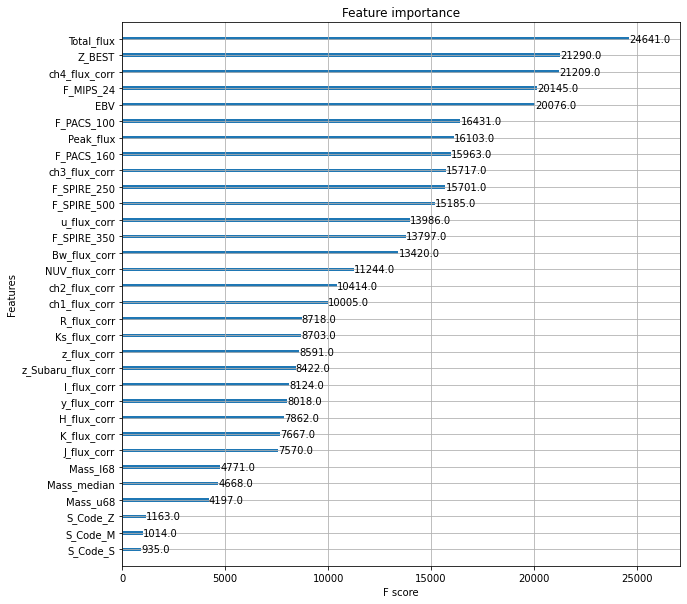

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, ax=ax)

# DNN

In [101]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dic = {i:class_weight[i] for i in range(4)}

In [102]:
model = keras.Sequential(
    [
        keras.layers.Dense(
            256, activation="relu", input_shape=(X_train.shape[1],)
        ),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(4),
    ]
)

In [111]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="Adam",
    metrics=["accuracy"],
)

In [112]:
model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    verbose=2,
    #callbacks=callbacks,
    validation_data=(X_test, y_test),
    #class_weight=class_weight_dic,
)

Epoch 1/100
444/444 - 3s - loss: 0.8535 - accuracy: 0.7154 - val_loss: 0.7869 - val_accuracy: 0.7296
Epoch 2/100
444/444 - 1s - loss: 0.7909 - accuracy: 0.7235 - val_loss: 0.7466 - val_accuracy: 0.7363
Epoch 3/100
444/444 - 2s - loss: 0.7408 - accuracy: 0.7431 - val_loss: 0.6982 - val_accuracy: 0.7569
Epoch 4/100
444/444 - 2s - loss: 0.6953 - accuracy: 0.7575 - val_loss: 0.6416 - val_accuracy: 0.7716
Epoch 5/100
444/444 - 2s - loss: 0.6683 - accuracy: 0.7661 - val_loss: 0.6750 - val_accuracy: 0.7685
Epoch 6/100
444/444 - 2s - loss: 0.6485 - accuracy: 0.7723 - val_loss: 0.6811 - val_accuracy: 0.7733
Epoch 7/100
444/444 - 2s - loss: 0.6283 - accuracy: 0.7752 - val_loss: 0.5903 - val_accuracy: 0.7924
Epoch 8/100
444/444 - 2s - loss: 0.6231 - accuracy: 0.7803 - val_loss: 0.5956 - val_accuracy: 0.7879
Epoch 9/100
444/444 - 2s - loss: 0.6096 - accuracy: 0.7857 - val_loss: 0.5849 - val_accuracy: 0.7939
Epoch 10/100
444/444 - 2s - loss: 0.6006 - accuracy: 0.7864 - val_loss: 0.5810 - val_accura

Epoch 82/100
444/444 - 2s - loss: 0.4393 - accuracy: 0.8372 - val_loss: 0.4694 - val_accuracy: 0.8314
Epoch 83/100
444/444 - 2s - loss: 0.4377 - accuracy: 0.8366 - val_loss: 0.4751 - val_accuracy: 0.8283
Epoch 84/100
444/444 - 2s - loss: 0.4345 - accuracy: 0.8373 - val_loss: 0.5005 - val_accuracy: 0.8342
Epoch 85/100
444/444 - 2s - loss: 0.4369 - accuracy: 0.8395 - val_loss: 0.4677 - val_accuracy: 0.8387
Epoch 86/100
444/444 - 2s - loss: 0.4323 - accuracy: 0.8398 - val_loss: 0.4919 - val_accuracy: 0.8345
Epoch 87/100
444/444 - 2s - loss: 0.4322 - accuracy: 0.8409 - val_loss: 0.4966 - val_accuracy: 0.8316
Epoch 88/100
444/444 - 2s - loss: 0.4362 - accuracy: 0.8373 - val_loss: 0.4786 - val_accuracy: 0.8370
Epoch 89/100
444/444 - 2s - loss: 0.4297 - accuracy: 0.8399 - val_loss: 0.4814 - val_accuracy: 0.8356
Epoch 90/100
444/444 - 2s - loss: 0.4345 - accuracy: 0.8378 - val_loss: 0.4899 - val_accuracy: 0.8333
Epoch 91/100
444/444 - 2s - loss: 0.4369 - accuracy: 0.8372 - val_loss: 0.4686 - v